In [ ]:
#imports
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms,models
import helper
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler
      


In [ ]:
#check if cuda is avaliable
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print("training on gpu")
else:
  print("not training on gpu")  

training on gpu


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip -q /content/gdrive/'My Drive'/Tomato_data.zip

In [ ]:
#directories
train_dir='/content/Tomato_data/train_set'
valid_dir='/content/Tomato_data/val_set'


In [ ]:

#transformations
train_transform=transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
valid_transform=transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

#load data
trainset=datasets.ImageFolder(train_dir,transform=train_transform)
validset=datasets.ImageFolder(valid_dir,transform=valid_transform)



In [ ]:
#prepare data loaders
trainloader=torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)

validloader=torch.utils.data.DataLoader(validset,batch_size=64,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

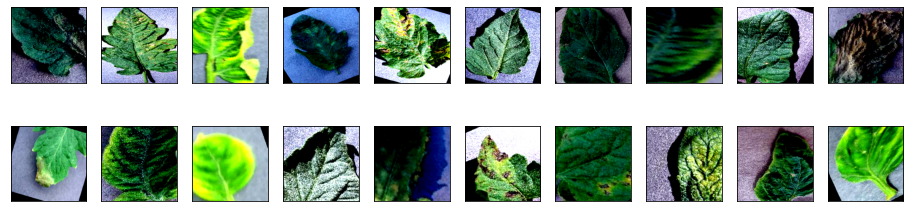

In [ ]:
def show_images(img):
    img=img/2 + 0.5
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
#get one batch
dataiter =iter(trainloader)
images,labels=dataiter.next()


fig = plt.figure(figsize=(16, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    show_images(images[idx])



In [ ]:
#build model
#pretrained model
model=models.resnet18(pretrained=True)
for params in model.parameters():
    #freeze
    params.requre_grad=True

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#build the classifier artitechture

model.fc.out_features=11
model.fc

Linear(in_features=512, out_features=11, bias=True)

In [ ]:
#build your classifier

#from collections import OrderedDict
#classifier=nn.Sequential(OrderedDict([
      #('fc1',nn.Linear(9216,4096)),
       # ('relu',nn.ReLU()),
       # ('dropout',nn.Dropout(p=0.35)),
        #('fc2',nn.Linear(4096,512)),
       # ('relu',nn.ReLU()),
        #('dropout',nn.Dropout(p=0.1)),
       # ('fc3',nn.Linear(512,11)),
        #('output',nn.LogSoftmax(dim=1))]))
#model.classifier=classifier     '''

In [ ]:
def forward(self,x):
    x=model(x)
    return x

In [ ]:
#define loss and gradient function
optimizer=torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=15,gamma=0.1)


In [ ]:
#move model to GPU
if train_on_gpu:
    model=model.cuda()
#train model
epochs=30
losses=[]
valid_loss_min=np.Inf
for e in range(epochs):
    
    
    #train phase
    train_loss=0
    for ii ,(images,labels) in enumerate(trainloader):
        #clear gradients
        optimizer.zero_grad()
        #move images awith torch.set_grad_enabled(False):nd labels to gpu
        if train_on_gpu:
            images=images.cuda()
            labels=labels.cuda()
        output_t=model(images)
        loss_t=criterion(output_t,labels)
        loss_t.backward()
        train_loss+=loss_t.item()
        optimizer.step()
    
        
    else:
        #validation phase  
        valid_loss=0
        accuracy=0
    
        with torch.set_grad_enabled(False):
            
            for ii,(images,labels) in enumerate(validloader):
                if train_on_gpu:
                    images=images.cuda()
                    labels=labels.cuda()
                output_v=model(images)
                loss_v=criterion(output_v,labels)
                valid_loss+=loss_v.item()
                #get accuracy
                ps=torch.exp(output_v)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
           
    print(f"Epochs:{e+1}/{epochs}...",
               f"trainloss: {train_loss/len(trainloader):.3f}...",
                f"validloss: {valid_loss/len(validloader):.3f}...",
                f"Accuracy:{accuracy*100/len(validloader):.2f}...."
               )
        
         
       #save model when validation loss has decreased
    if valid_loss/len(validloader)<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss/len(validloader)))
        torch.save(model,'classifier.pth')
        valid_loss_min=valid_loss/len(validloader)
    
    model.train()

Epochs:1/30... trainloss: 2.281... validloss: 1.082... Accuracy:64.10....
Validation loss decreased (inf --> 1.081784).  Saving model ...
Epochs:2/30... trainloss: 1.013... validloss: 0.678... Accuracy:78.32....
Validation loss decreased (1.081784 --> 0.678203).  Saving model ...
Epochs:3/30... trainloss: 0.745... validloss: 0.526... Accuracy:83.41....
Validation loss decreased (0.678203 --> 0.525619).  Saving model ...
Epochs:4/30... trainloss: 0.637... validloss: 0.452... Accuracy:85.83....
Validation loss decreased (0.525619 --> 0.451892).  Saving model ...
Epochs:5/30... trainloss: 0.566... validloss: 0.412... Accuracy:87.07....
Validation loss decreased (0.451892 --> 0.411951).  Saving model ...
Epochs:6/30... trainloss: 0.530... validloss: 0.383... Accuracy:88.13....
Validation loss decreased (0.411951 --> 0.383094).  Saving model ...
Epochs:7/30... trainloss: 0.501... validloss: 0.363... Accuracy:89.01....
Validation loss decreased (0.383094 --> 0.363047).  Saving model ...
